# Predict Ames House Price - Advanced Regression Techniques

In [1]:
__author__ = "Chris Tran"
__email__ = "tranduckhanh96@gmail.com"
__website__ = "chriskhanhtran.github.io"

# Part 2: Data Preprocessing and Modeling
**Read more: [Part 1: Exploratory Data Analysis](https://chriskhanhtran.github.io/projects/ames-house-price-part1.html)**
![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)
## Table of Contents

- [**3. Data preprocessing**](#3-data-preprocessing)

    - 3.1. [Missing values](#3.1-missing-values)
    
    - 3.2. [Outliers](#3.2-outliers)
    
    - 3.3. [Feature engineering](#3.3-feature-engineering)
        - 3.3.1. [Create new variables](#3.3.1-create-new-variables)
        - 3.3.2. [Label encoding](#3.3.2-label-encoding)
        - 3.3.3. [Transform numerical variables to categorical variables](#3.3.3-transform-variables)
    - 3.4. [Skewness and normalizing variables](#3.4-skewness)
    
    - 3.5. [Feature scaling](#3.5-feature-scaling)
    
    - 3.6. [One-hot encoding](#3.6-one-hot-encoding)
- [**4. Modeling**](#4-modeling)

    - 4.1. [Regularized Regressions](#4.1-regularized-regression)
        - 4.1.1. [Ridge Regression](#4.1.1-ridge)
        - 4.1.2. [Lasso Regression](#4.1.2-lasso)
    - 4.2. [XGBoost](#4.2-xgboost)
    
    - 4.4. [LightGBM](#4.3-lightgbm)
    
    - 4.5. [Averaging model](#4.4-averaging-model)

- [**5. Conclusion**](#5-conclusion)

**Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set_style('darkgrid')

**Load data**

In [3]:
# Load data
train_data = pd.read_csv('Data/train.csv', index_col='Id')
test_data = pd.read_csv('Data/test.csv', index_col='Id')

# Seperate features and target variable
X_train = train_data.drop(['SalePrice'], axis=1)
y = train_data.SalePrice

# Concatenate train and test data
X = pd.concat([X_train, test_data], axis=0)

## 3. Data preprocessing <a name="3-data-preprocessing"></a>
### 3.1. Missing values <a name="3.1-missing-values"></a>

In [4]:
missing_data_count = X.isnull().sum()
missing_data_percent = X.isnull().sum()/len(X)*100
missing_data = pd.DataFrame({'Count': missing_data_count, 'Percent': missing_data_percent})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

In [5]:
missing_data.head(10)

,Count,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071
GarageYrBlt,159,5.447071


There are 34 features that have missing values. I will divide them into three groups based on the data description:
   - **Group 1 - Categorical variables where `NA` means no feature:** `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu`, `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `MasVnrType` (15 variables)
   
    For this group I will impute `NA` with `'None'`.
    
   - **Group 2 - Numerical variables where `NA` means no feature:** `GarageArea`, `GarageCars`, `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath`, `MasVnrArea` (10 variables)
   
    For this group I will impute `NA` with `0`.
    
   - **Group 3 - Other variables:** `Functional`, `MSZoning`, `Electrical`, `KitchenQual`, `Exterior1st`, `Exterior2nd`, `SaleType`, `Utilities`, `LotFrontage`, `GarageYrBlt` (9 variables)
        - I will impute `Functional`, `MSZoning`, `Electrical`, `KitchenQual`, `Exterior1st`, `Exterior2nd`, `SaleType`, `Utilities` with their *modes*,
        - impute `LotFrontage` with its *mean*,
        - impute `GarageYrBlt` with `YearBuilt`.

In [6]:
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual',
           'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
X[group_1] = X[group_1].fillna("None")

# Group 2:
group_2 = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
           'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

X[group_2] = X[group_2].fillna(0)

# Group 3:
group_3a = ['Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
            'Exterior2nd', 'SaleType', 'Utilities']

imputer = SimpleImputer(strategy='most_frequent')
X[group_3a] = pd.DataFrame(imputer.fit_transform(X[group_3a]), index=X.index)

X.LotFrontage = X.LotFrontage.fillna(X.LotFrontage.mean())
X.GarageYrBlt = X.GarageYrBlt.fillna(X.YearBuilt)

Let's check whether there is any missing value left:

In [7]:
sum(X.isnull().sum())

0

Great! All missing values have been handled.

### 3.2. Outliers <a name="3.2-outliers"></a>

Because regression models are very sensitive to outlier, we need to be aware of them. Let's examine outliers with a scatter plot.

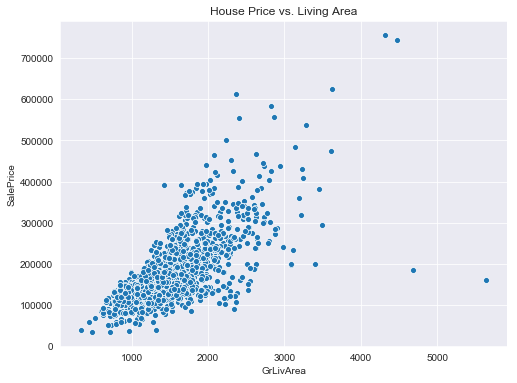

In [8]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)
title = plt.title('House Price vs. Living Area')

There are two observations lying separately from the rest. They have large living area but low price. They are the outliers that we are looking for. I will delete them from the training set.

In [9]:
outlier_index = train_data[(train_data.GrLivArea > 4000) & (train_data.SalePrice < 200000)].index
X.drop(outlier_index, axis=0, inplace=True)
y.drop(outlier_index, axis=0, inplace=True)

### 3.3. Feature engineering <a name="3.3-feature-engineering"></a>
#### 3.3.1. Create new variables <a name="3.3.1-create-new-variables"></a>
In this step I will create new features from weaker features in the training data. For example, the surface area of each floor has low correlation with house price; however, when we sum them up, the relationship becomes much stronger. In fact, `TotalSqFeet` becomes the strongest feature in the dataset. The new features I will create are **total square feet, total number of bathrooms, age of the house, whether the house was remodeled, and whether the house was sold in the same year it was built.**

In [10]:
X['totalSqFeet'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['totalBathroom'] = X.FullBath + X.BsmtFullBath + 0.5*(X.HalfBath + X.BsmtHalfBath)
X['houseAge'] = X.YrSold - X.YearBuilt
X['reModeled'] = np.where(X.YearRemodAdd==X.YearBuilt, 0, 1)
X['isNew'] = np.where(X.YrSold==X.YearBuilt, 1, 0)

#### 3.3.2. Label encoding <a name="3.3.2-label-encoding"></a>
Ordinal categorical features are label encoded.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Ordinal categorical columns
label_encoding_cols = ["Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                       "BsmtQual", "ExterCond", "ExterQual", "FireplaceQu", "Functional",
                       "GarageCond", "GarageQual", "HeatingQC", "KitchenQual", "LandSlope",
                       "LotShape", "PavedDrive", "PoolQC", "Street", "Utilities"]

# Apply Label Encoder
label_encoder = LabelEncoder()

for col in label_encoding_cols:
    X[col] = label_encoder.fit_transform(X[col])

#### 3.3.3. Transform numerical variables to categorical variables <a name="3.3.3-transform-variables"></a>

Because I have calculated age of houses, `YearBuilt` is no longer needed. However, `YrSold` could have a large impact on house price (e.g. In economic crisis years, house price could be lower). Therefore, I will transform it into categorical variables.

Like `YrSold`, some numerical variables don't have any ordinal meaning (e.g. `MoSold`, `MSSubClass`). I will transform them into categorical variables.

In [12]:
to_factor_cols = ['YrSold', 'MoSold', 'MSSubClass']

for col in to_factor_cols:
    X[col] = X[col].apply(str)

### 3.4. Skewness and normalizing variables <a name="3.4-skewness"></a>

Normal distribution is one of the assumption that linear regression relies on. Therefore, transfoming skewed data will help our models perform better.

First, let's examine the target variable `SalePrice` with Distribution plot and Quantile-Quantile plot.

**Target variable**

In [13]:
from scipy import stats
from scipy.stats import norm

In [14]:
def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    
    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')
    
    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()

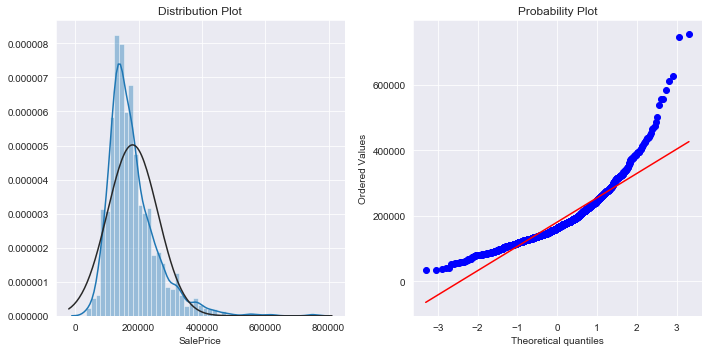

In [15]:
normality_plot(y)

One of the methods to normalize right-skewed data is using log transformation because big values will be pulled to the center. However, log(0) is Nan, so I will use log(1+X) to fix skewness instead.

In [16]:
y = np.log(1+y)

And this is `SalePrice` after log transformation. The sknewness has been fixed.

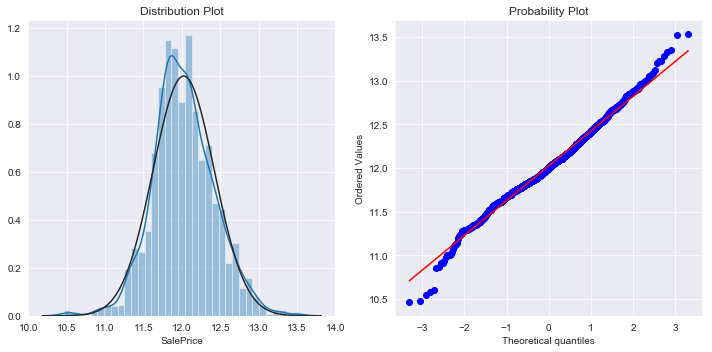

In [17]:
normality_plot(y)

In the next step I will examine skewness in the rest of numerical variables and use log transformation to fix them,

**Fixing skewness in other numerical variables**

If skewness is less than -1 or greater than 1, the distribution is **highly skewed**.

If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is **moderately skewed**.

If skewness is between -0.5 and 0.5, the distribution is **approximately symmetric**.

Below are skewed features in our original train data.

In [18]:
skewness = train_data.skew().sort_values(ascending=False)
skewness[abs(skewness) > 0.75]

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
dtype: float64

Let's check normality of `GrLivArea`:

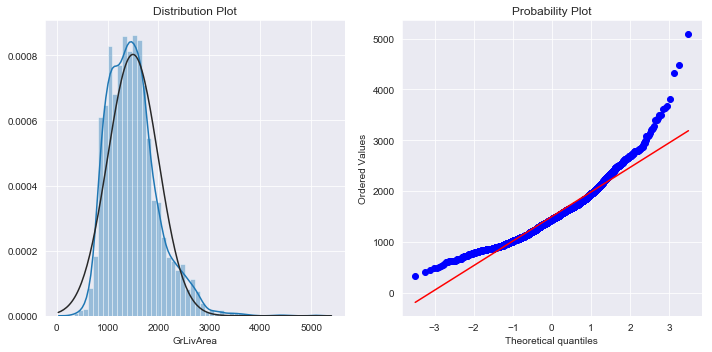

In [19]:
normality_plot(X.GrLivArea)

In [20]:
# List of skewed columns
skewed_cols = list(skewness[abs(skewness) > 0.5].index)

# Remove 'MSSubClass' and 'SalePrice'
skewed_cols = [col for col in skewed_cols if col not in ['MSSubClass', 'SalePrice']]

# Log-transform skewed columns
for col in skewed_cols:
    X[col] = np.log(1+X[col])

Below is normality of `GrLivArea` after log-transformation. Skewness has been fixed.

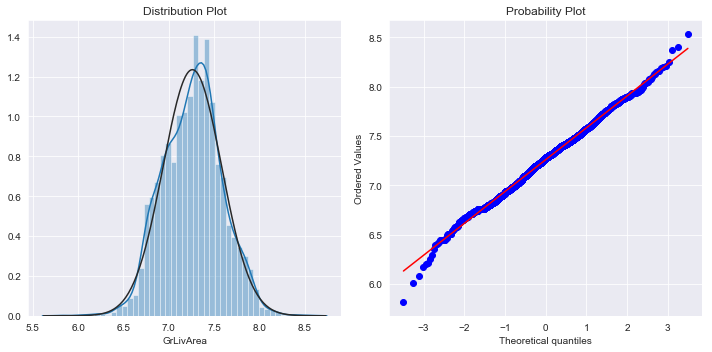

In [21]:
normality_plot(X.GrLivArea)

### 3.5. Feature scaling <a name="3.5-feature-scaling"></a>

Except for Decision Tree and Random Forest, it is highly recommended to standardize the data set before running machine learning algorithms since optimization methods and gradient descent run and converge faster on similarly scaled features.

However, outliers can often influence the sample mean and standard deviation in a negative way, and models like Lasso and Elastic Net are very sensitive to outliers. In such cases, the median and the interquartile range often give better results. I will use [**RobustScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) to transform the training data.

In [22]:
from sklearn.preprocessing import RobustScaler
numerical_cols = list(X.select_dtypes(exclude=['object']).columns)
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

### 3.6. One-hot encoding <a name="3.6-one-hot-encoding"></a>

In [23]:
X = pd.get_dummies(X, drop_first=True)
print("X.shape:", X.shape)

X.shape: (2917, 237)


After preprocessing the train and test data, I split them again to perform modeling.

In [24]:
ntest = len(test_data)
X_train = X.iloc[:-ntest, :] 
X_test = X.iloc[-ntest:, :]
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (1458, 237)
X_test.shape: (1459, 237)


## 4. Modeling <a name="4-modeling"></a>

In model evaluation, it's a common practice to split the entire training data into 2 sets of data (train and test). However, a model may work very well on a set of test data but have a poor performance on other sets of unseen data.

A solution to this problem is a procedure called [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) (CV). In the example below, under the basic approach, called k-fold CV, the training set is split into `5` smaller sets. Then, for each fold, a model is trained using the other `4` folds and evaluated on the remaining fold. The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="400" height="200" alt="CV">

I will write a function to get the **Root Mean Squared Logarithmic Error (RMSLE)** for my models using cross-validation. There is one note here: because I have transformed the target variable to *log(1+y)* , the **Mean Squared Error** for *log(1+y)* is the **Mean Squared Logarithmic Error** for `SalePrice`.

In [25]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)
    
    # Get RMSLE score
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=kf))
    
    return rmse.mean()

### 4.1. Regularized Regressions <a name="4.1-regularized-regression"></a>

In [26]:
from sklearn.linear_model import Ridge, Lasso

#### 4.1.1. Ridge Regression <a name="4.1.1-ridge"></a>

In the regularized linear regression (Ridge), we try to minimize:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well.

I will find the $\lambda$ that gives me the smallest **RMSLE** from cross-validation:

Best lambda: 22.9
RMSLE: 0.11409306668450885


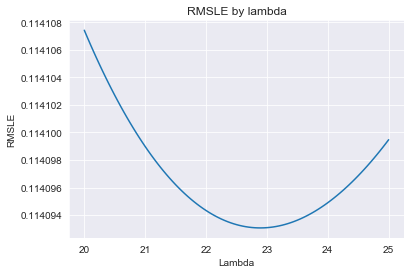

In [27]:
lambda_list = list(np.linspace(20, 25, 101))

rmsle_ridge = [getRMSLE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=lambda_list)

rmsle_ridge.plot(title = "RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [28]:
ridge = Ridge(alpha=22.9)

#### 4.1.2. Lasso Regression <a name="4.1.2-lasso"></a>

Lasso Regression is very similar to Ridge regression. One difference is that in the regularization term, instead of using **sum of squared of $\theta$**, we use **sum of absolute value of $\theta$**:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n |\theta_j| \right)$$

Another big difference is that Ridge Regresion can only shrink parameters close to zero while Lasso Regression can shrink some parameters all the way to 0. Therefore, we can use Lasso Regression to perform feature selection and regression.

With the same method above, the best `lambda_` for my Lasso model is **0.00065**.

Best lambda: 0.00065
RMSLE: 0.11335701578061286


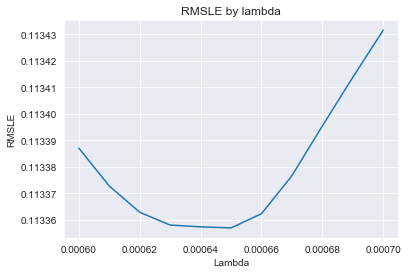

In [29]:
lambda_list = list(np.linspace(0.0006, 0.0007, 11))
rmsle_lasso = [getRMSLE(Lasso(alpha=lambda_, max_iter=100000)) for lambda_ in lambda_list]
rmsle_lasso = pd.Series(rmsle_lasso, index=lambda_list)

rmsle_lasso.plot(title = "RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_lasso.idxmin())
print("RMSLE:", rmsle_lasso.min())

In [30]:
lasso = Lasso(alpha=0.00065, max_iter=100000)

### 4.2. XGBoost <a name="4.2-xgboost"></a>
Following this [complete guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?fbclid=IwAR1NTAXqgYzjOOFw3qOV5DrcItwNoM73iPvWggnuyVR1PbvORiEUjRunipo) of parameter tuning for XGBoost, I respectively tune and find the best parameter for  `n_estimators` `max_depth` `min_child_weight` `gamma` `subsample` `colsample_bytree` `reg_alpha` `reg_lambda` `learning_rate`.

In [31]:
from xgboost import XGBRegressor

In [32]:
xgb = XGBRegressor(learning_rate=0.05,
                   n_estimators=2100,
                   max_depth=2,
                   min_child_weight=2,
                   gamma=0,
                   subsample=0.65,
                   colsample_bytree=0.46,
                   nthread=-1,
                   scale_pos_weight=1,
                   reg_alpha=0.464,
                   reg_lambda=0.8571,
                   silent=1,
                   random_state=7,
                   n_jobs=2)
getRMSLE(xgb)

0.11606095711193823

### 4.3. LightGBM <a name="4.3-lightgbm"></a>

LightGBM is a powerful gradient boosting framework based on decision tree algorithm. Like XGBoost, LightGBM has a high performance on large data sets  but much faster training speed than XGBoost does. Following [this guide](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/?fbclid=IwAR3uYr9U1VDaqh_jEn1cjvMyjEWVHKMaDm_Q9yD1y08OkGBywRR0qpuhhtw), I have tuned the parameters `num_leaves` `min_data_in_leaf` `max_depth` `bagging_fraction` `feature_fraction` `max_bin`. As you can see in the RMSLE reported below, for this data set LightGBM has better performance than XGBoost.

In [33]:
from lightgbm import LGBMRegressor

In [34]:
lgb = LGBMRegressor(objective='regression',
                    learning_rate=0.05,
                    n_estimators=730,
                    num_leaves=8,
                    min_data_in_leaf=4,
                    max_depth=3,
                    max_bin=55,
                    bagging_fraction=0.78,
                    bagging_freq=5,
                    feature_fraction=0.24,
                    feature_fraction_seed=9,
                    bagging_seed=9,
                    min_sum_hessian_in_leaf=11)
getRMSLE(lgb)

0.11363365457925714

### 4.4. Averaging model <a name="4.4-averaging-model"></a>

Regularized regression and gradient boosting work very differently and they may perform well on different data points. Thus it is a good practice to get average predictions from these models. Below I create a new class for my averaging model.

In [35]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Create clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        # Get predictions from trained clone models
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        
        # Return average predictions
        return np.mean(predictions, axis=1)

In [36]:
avg_model = AveragingModel(models=(ridge, lasso, xgb, lgb))
getRMSLE(avg_model)

0.11018696734100766

The RMSLE score of the averaging model is much better than any of base models. I will use this model as my final model. In the last step, I will train my final model on the whole training data, make predictions from the test data and save my output.

In [37]:
my_model = avg_model
my_model.fit(X_train, y)
predictions = my_model.predict(X_test)

final_predictions = np.exp(predictions) - 1

output = pd.DataFrame({'Id': test_data.index,
                       'SalePrice': final_predictions})
output.to_csv('submission.csv', index=False)

## 5. Conclusion <a name="5-conclusion"></a>

After my first two data science projects solving classification problems, I decided to work on the Ames housing dataset to expand my skill set to solve regression problems. In this project, first I conducted a detailed EDA to understand the data and important features. Based on my exploratory analysis from Part 1, I performed data preprocessing and feature engineering. Finally, I train regularized regression models (Ridge, Lasso), XGBoost and LightGBM, and take average predictions from these models to predict final price of each house. By the time I write this notebook, my best model has **Mean Absolute Error** of **12383.11473**, ranking 98/14779, approximately top 0.6% in the Kaggle leaderboard.

Thank you for reading this project. I hope you enjoy it. Please feel free to contact me know if you have any question.

**Read more: [Part 1: Exploratory Data Analysis](https://chriskhanhtran.github.io/projects/ames-house-price-part1.html)**